# Concrete Crack Classification

## Data Preparation

### Import necessary modules

In [20]:
import numpy as np
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt
import datetime
import os
from tensorflow.keras.preprocessing import image_dataset_from_directory

### Load the dataset 

In [21]:
file_path = r"C:\Users\Muhamad Siddiq\Desktop\SHRDC\GitHub-Repo\Concrete Crack"
data_dir = pathlib.Path(file_path)

### Splitting the dataset into training = 70%, validation = 15% and testing = 15%

In [24]:
SEED = 12345
IMG_SIZE = (160,160)
BATCH_SIZE = 16
train_dataset = image_dataset_from_directory(data_dir,validation_split=0.3,subset='training',seed=SEED,shuffle=True,image_size=IMG_SIZE,batch_size=BATCH_SIZE)
val_dataset = image_dataset_from_directory(data_dir,validation_split=0.3,subset='validation',seed=SEED,shuffle=True,image_size=IMG_SIZE,batch_size=BATCH_SIZE)

Found 40000 files belonging to 3 classes.
Using 28000 files for training.
Found 40000 files belonging to 3 classes.
Using 12000 files for validation.


In [25]:
val_batches = tf.data.experimental.cardinality(val_dataset)
test_dataset = val_dataset.take(val_batches//5)
validation_dataset = val_dataset.skip(val_batches//5)

### Creating prefetch dataset

In [26]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset_pf = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset_pf = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset_pf = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Transfer learning model

### Define a layer that preprocess inputs for the transfer learning model

In [27]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

We are using MobileNetV2

### Creating the base model 

In [29]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')

### Freeze the base model and view the model structure

In [30]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

### Create classification layers with global average pooling and dense layer

In [31]:
class_names = train_dataset.class_names
global_avg_pool = tf.keras.layers.GlobalAveragePooling2D()
output_dense = tf.keras.layers.Dense(len(class_names),activation='softmax')

### Build the complete model by using Functional API

In [33]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = preprocess_input(inputs)
x = base_model(x)
x = global_avg_pool(x)
outputs = output_dense(x)

model = tf.keras.Model(inputs,outputs)
#Print out the model structure
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_______________________________________________

### Compile the model

In [35]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss = tf.keras.losses.SparseCategoricalCrossentropy()

model.compile(optimizer=adam,loss=loss,metrics=['accuracy'])

### Perform training

In [39]:
EPOCHS = 10
BATCH_SIZE = 32

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,verbose=2)
history = model.fit(train_dataset_pf,validation_data=validation_dataset_pf,epochs=EPOCHS,batch_size = BATCH_SIZE,callbacks=[es_callback])

Epoch 1/10
1750/1750 [==============================] - 124s 71ms/step - loss: 0.0052 - accuracy: 0.9985 - val_loss: 0.0055 - val_accuracy: 0.9985
Epoch 2/10
1750/1750 [==============================] - 124s 71ms/step - loss: 0.0042 - accuracy: 0.9988 - val_loss: 0.0052 - val_accuracy: 0.9986
Epoch 3/10
1750/1750 [==============================] - 117s 67ms/step - loss: 0.0035 - accuracy: 0.9991 - val_loss: 0.0048 - val_accuracy: 0.9987
Epoch 4/10
1750/1750 [==============================] - 118s 67ms/step - loss: 0.0031 - accuracy: 0.9992 - val_loss: 0.0046 - val_accuracy: 0.9987
Epoch 5/10
1750/1750 [==============================] - 122s 70ms/step - loss: 0.0027 - accuracy: 0.9994 - val_loss: 0.0045 - val_accuracy: 0.9987
Epoch 6/10
1750/1750 [==============================] - 121s 69ms/step - loss: 0.0024 - accuracy: 0.9995 - val_loss: 0.0044 - val_accuracy: 0.9990
Epoch 7/10
1750/1750 [==============================] - 122s 70ms/step - loss: 0.0022 - accuracy: 0.9997 - val_loss: 0

## Plotting the Training vs Validation Loss and Training vs Validation Accuracy

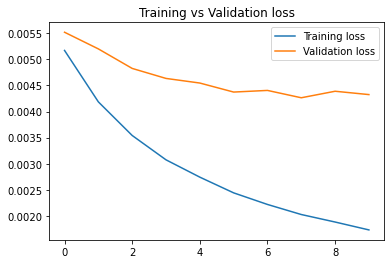

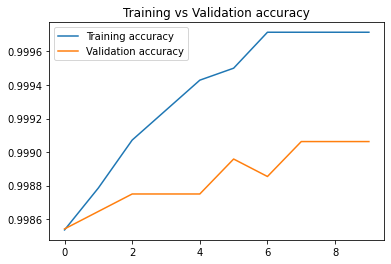

<Figure size 432x288 with 0 Axes>

In [40]:
import matplotlib.pyplot as plt

train_loss = history.history["loss"]
val_loss = history.history["val_loss"]
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
epochs = history.epoch

plt.plot(epochs, train_loss, label="Training loss")
plt.plot(epochs, val_loss, label="Validation loss")
plt.title("Training vs Validation loss")
plt.legend()
plt.figure()

plt.plot(epochs, train_acc, label="Training accuracy")
plt.plot(epochs, val_acc, label="Validation accuracy")
plt.title("Training vs Validation accuracy")
plt.legend()
plt.figure()

plt.show()

## Evaluation

### Evaluate the model by using test dataset

In [41]:
test_loss,test_accuracy = model.evaluate(test_dataset_pf)

print('------------------------Test Result----------------------------')
print(f'Loss = {test_loss}')
print(f'Accuracy = {test_accuracy}')

150/150 [==============================] - 8s 54ms/step - loss: 0.0026 - accuracy: 0.9992
------------------------Test Result----------------------------
Loss = 0.0025857421569526196
Accuracy = 0.9991666674613953


## Make prediction by deploying the created model

In [44]:
image_batch, label_batch = test_dataset_pf.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)
class_predictions = np.argmax(predictions,axis=1)

### Show the prediction result

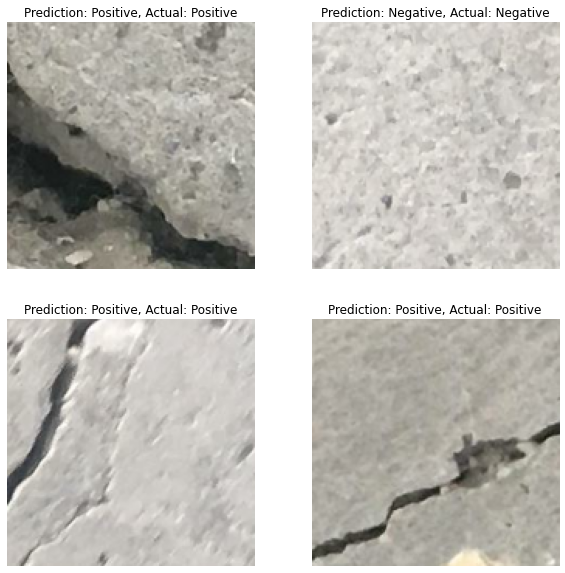

In [45]:
plt.figure(figsize=(10,10))

for i in range(4):
    axs = plt.subplot(2,2,i+1)
    plt.imshow(image_batch[i].astype('uint8'))
    current_prediction = class_names[class_predictions[i]]
    current_label = class_names[label_batch[i]]
    plt.title(f"Prediction: {current_prediction}, Actual: {current_label}")
    plt.axis('off')
    
save_path = r"C:\Users\Muhamad Siddiq\Desktop\SHRDC\GitHub-Repo\Concrete Crack"
plt.savefig(os.path.join(save_path,"result.png"),bbox_inches='tight')
plt.show()